In [306]:
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import MinMaxScaler
import math

Step 0: Compute the mean std, and var for each KPI
Step 1: Normalize the dataset (mean var)
Step 2: Compute threshold 3 * std + mean/median using normalized value sum square sqrt(kpi1^2 + kpi2^2) for each timestamp
Step 3: Production normalize using normal data and compute sqrt(kpi1^2 + kpi2^2) for each timestamp and compare with threshold
Step 4: If above threshold: prediction yes, then localization. Get KPIs higher than threshold for KPI (anomalous KPIs) compared with 3 (mean is 0) (try)
Step 5: Anomalous KPIs Grouped by services to localize


## Load Dataset

In [307]:
PATH_DATASET_FOLDER = "./input/datasets/Consolidated"
PATH_NORMAL_DATASET = os.path.join(
    PATH_DATASET_FOLDER, "normal-2weeks", "normal-2weeks.csv"
)
PATH_FAILURE_DATASET_FOLDER = os.path.join(PATH_DATASET_FOLDER, "failure-experiments")
PATH_FAILURE_LOGS = os.path.join(
    PATH_FAILURE_DATASET_FOLDER, "failure-injection-logs-with-disruption.csv"
)
PATH_DATASET_CONFIG = "data_sets_config.csv"

In [308]:
with open(
    "./input/other/services.yaml"
) as fp:
    SERVICES = yaml.safe_load(fp)["services"]

In [106]:
df_normal = pd.read_csv(PATH_NORMAL_DATASET)
if "timestamp" in df_normal:
    df_normal.set_index("timestamp", inplace=True)
print(f"Shape of the preprocessed normal dataset: {df_normal.shape}")

Shape of the preprocessed normal dataset: (19996, 12525)


In [107]:
df_failure_logs = pd.read_csv(PATH_FAILURE_LOGS)

In [225]:
df_dataset_config = pd.read_csv(PATH_DATASET_CONFIG)

In [251]:
# dict of failure name -> DataFrame
failure_experiment_dict = {
    experiment: pd.read_csv(
        os.path.join(PATH_FAILURE_DATASET_FOLDER, experiment, f"{experiment}.csv")
    ).set_index("timestamp")
    for experiment in df_dataset_config["code"]
}

In [232]:
print(f"Shape of failure datasets:")
for failure_name, df_failure in failure_experiment_dict.items():
    print(failure_name + ":", df_failure.shape)

Shape of failure datasets:
linear-cpu-stress-ts-station-service-020211: (181, 12615)
linear-cpu-stress-ts-basic-service-020616: (180, 12195)
linear-cpu-stress-ts-train-service-020713: (181, 12063)
linear-memory-stress-ts-station-service-021917: (241, 15186)
linear-memory-stress-ts-basic-service-022009: (240, 14706)
linear-memory-stress-ts-train-service-021316: (240, 14173)
linear-network-delay-ts-station-service-013016: (180, 12652)
linear-network-delay-ts-basic-service-020911: (181, 13859)
linear-network-delay-ts-train-service-020116: (181, 12449)


## Normalize

In [127]:
normal_values = df_normal.fillna(0).values.astype(float)
scaler = MinMaxScaler()
scaler.fit(normal_values)
normal_values = scaler.transform(normal_values)
df_normalized_normal = pd.DataFrame(normal_values, columns=df_normal.columns)

In [252]:
for failure_name, df_failure in failure_experiment_dict.items():
    df_failure, _ = df_failure.align(df_normalized_normal, join="right", axis=1)
    failure_values = df_failure.fillna(0).values.astype(float)
    failure_experiment_dict[failure_name] = pd.DataFrame(
        scaler.transform(failure_values), columns=df_failure.columns
    )

## Predict Failures

In [145]:
def compute_threshold(kpi: pd.Series):
    # Each KPI threshold is computed by the mean plus 3 times standard deviation
    return kpi.mean() + 3 * kpi.std()


def compute_timestamp_state(s: pd.Series):
    return s.mean()

In [179]:
df_kpi_threshold = df_normalized_normal.apply(compute_threshold)

In [172]:
df_normal_states = df_normalized_normal.apply(compute_timestamp_state, axis=1)
anomalous_state_threshold = compute_threshold(df_normal_states)

In [236]:
def compute_service_deviation(s):
    s[s <= 0] = np.nan
    return s.mean()


def compute_localization(df_service_rank, attacked_service, related_services):
    def localize_failures(s):
        if s["rank-1"] == attacked_service:
            # strong localization
            return 1
        elif (
            s["rank-2"] == attacked_service
            or s["rank-3"] == attacked_service
            or s["rank-1"] in related_services
        ):
            # weak localization
            return 2
        else:
            # no localization
            return 0

    return df_service_rank.apply(localize_failures, axis=1).to_list()

In [253]:
results = {}
for failure_name, df_failure in failure_experiment_dict.items():
    # prediction
    production_states = df_failure.apply(compute_timestamp_state, axis=1)
    predictions = list(production_states > anomalous_state_threshold)

    dataset_config = df_dataset_config[df_dataset_config["code"] == failure_name].iloc[
        0
    ]
    attacked_service = dataset_config["Attacked Service"] + "-service"
    related_services = [
        service + "-service" for service in dataset_config["Related Service"].split(":")
    ]

    # localization
    service_deviation_list = []
    df_failure = df_failure.sub(df_kpi_threshold, axis="columns")
    for service in SERVICES:
        service_column_mask = df_failure.columns[
            df_failure.columns.str.match(f".*(?:{service}).*")
        ]
        df_service_kpis = df_failure.loc[:, service_column_mask]

        service_deviation = df_service_kpis.apply(compute_service_deviation, axis=1)
        service_deviation.name = service
        service_deviation_list.append(service_deviation)
    df_service_deviations = pd.concat(service_deviation_list, axis=1)
    df_service_rank = pd.DataFrame(
        df_service_deviations.apply(
            lambda row: row.sort_values(ascending=False).index.to_list(), axis=1
        ).to_list(),
        columns=range(1, len(SERVICES) + 1),
    ).add_prefix("rank-")
    localizations = compute_localization(
        df_service_rank, attacked_service, related_services
    )
    results[failure_name] = {"predictions": predictions, "localizations": localizations}

## Predict and Localize Failures

The threshold of each KPI is computed by the mean plus 3 times standard deviation of the normal KPI
### Prediction
The deviation of each KPI is computed by subtracting the corresponding threshold from the value.

The deviation of a system state (identified by each timestamp) is the mean of the deviation of all KPIs.
- Predict `failure` if the deviation of the system state is above 0
- Predict `normal` otherwise

### Localization

The deviation of a service is the mean of the deviation of all KPIs from that service.


## Visualization

In [242]:
FAILURES_BY_TYPES = {
    "cpu_stress": [
        "linear-cpu-stress-ts-station-service-020211",
        "linear-cpu-stress-ts-basic-service-020616",
        "linear-cpu-stress-ts-train-service-020713",
    ],
    "memory_stress": [
        "linear-memory-stress-ts-station-service-021917",
        "linear-memory-stress-ts-train-service-021316",
        "linear-memory-stress-ts-basic-service-022009",
    ],
    "network_delay": [
        "linear-network-delay-ts-station-service-013016",
        "linear-network-delay-ts-basic-service-020911",
        "linear-network-delay-ts-train-service-020116",
    ],
}
ATTACKED_SERVICES = [
    "station",
    "basic",
    "train",
]

In [243]:
df_failure_logs["Disruption"].fillna(100, inplace=True)

In [279]:
baseline_statistcis = []

cpu_stress station false alarm rate: 67
cpu_stress station miss alarm rate: 0
cpu_stress station false localization rate: 4
cpu_stress station overall true localization rate: 96
67\% & 0\% & 4\% & 96\%
cpu_stress basic false alarm rate: 50
cpu_stress basic miss alarm rate: 3
cpu_stress basic false localization rate: 3
cpu_stress basic overall true localization rate: 94
50\% & 3\% & 3\% & 94\%
cpu_stress train false alarm rate: 3
cpu_stress train miss alarm rate: 67
cpu_stress train false localization rate: 0
cpu_stress train overall true localization rate: 33
3\% & 67\% & 0\% & 33\%
memory_stress station false alarm rate: 100
memory_stress station miss alarm rate: 0
memory_stress station false localization rate: 100
memory_stress station overall true localization rate: 0
100\% & 0\% & 100\% & 0\%
memory_stress train false alarm rate: 100
memory_stress train miss alarm rate: 0
memory_stress train false localization rate: 98
memory_stress train overall true localization rate: 2
100\% & 0

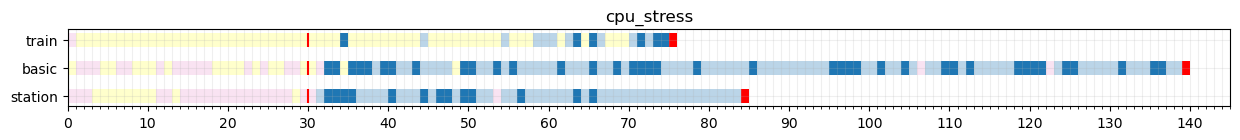

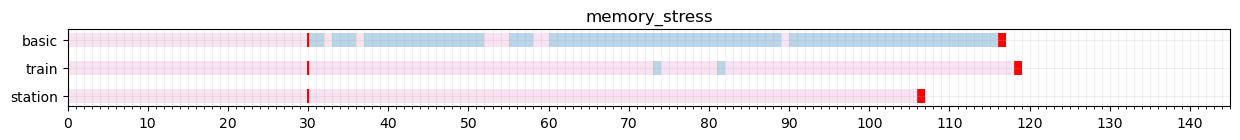

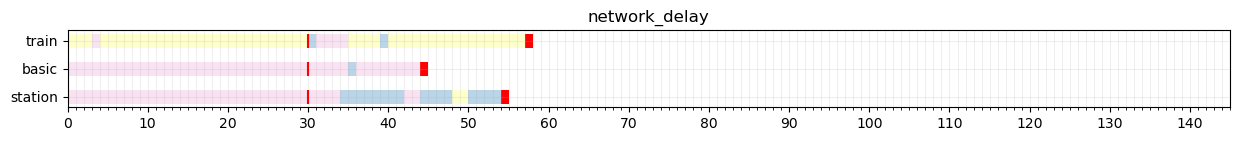

In [280]:
for failure_type in FAILURES_BY_TYPES.keys():
    fig, ax = plt.subplots(figsize=(15, 1))
    ax.set_title(failure_type)

    yticks = []
    ax.set_xlim(0, 145)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.grid(which="both", alpha=0.2)

    line_shift = 0
    for failure_name in FAILURES_BY_TYPES[failure_type]:
        # statistics
        num_false_alarms = 0
        num_miss_alarms = 0
        false_localizations = 0
        true_localizations = 0

        df_failure = failure_experiment_dict[failure_name]
        attacked_service = ""

        for service in ATTACKED_SERVICES:
            if service in failure_name:
                yticks.append(service)
                attacked_service = service
                break

        predictions = results[failure_name]["predictions"]
        localizations = results[failure_name]["localizations"].to_list()

        failure_log = df_failure_logs[
            df_failure_logs["folder_name"] == failure_name
        ].iloc[0]

        failure_begin_timestamp = datetime.fromisoformat(
            failure_log["failure_begin_timestamp"]
        ).timestamp()
        experiment_begin_timestamp = datetime.fromisoformat(
            failure_log["experiment_begin_timestamp"]
        ).timestamp()
        failure_injection_index = int(
            (failure_begin_timestamp - experiment_begin_timestamp) / 60
        )
        disruption_index = int(failure_log["Disruption"])

        # failure injection point
        ax.vlines(30, line_shift + 1, line_shift, color="red")

        # consider only 30 minutes before injection
        start_index = failure_injection_index - 30
        end_index = disruption_index
        predictions = predictions[start_index:end_index]
        localizations = localizations[start_index:end_index]

        for time_point in range(len(predictions)):
            prediction = predictions[time_point]
            localization = localizations[time_point]

            if prediction:
                if time_point < 30:
                    num_false_alarms += 1
                    ax.broken_barh(
                        [(time_point, 1)],
                        (line_shift, 1.0),
                        facecolors=("tab:pink"),
                        alpha=0.2,
                    )
                else:
                    if localization == 1:
                        ax.broken_barh(
                            [(time_point, 1)],
                            (line_shift, 1.0),
                            facecolors=("tab:blue"),
                            alpha=1,
                        )
                        true_localizations += 1

                    elif localization == 2:
                        ax.broken_barh(
                            [(time_point, 1)],
                            (line_shift, 1.0),
                            facecolors=("tab:blue"),
                            alpha=0.3,
                        )
                        true_localizations += 1

                    elif localization == 0:
                        ax.broken_barh(
                            [(time_point, 1)],
                            (line_shift, 1.0),
                            facecolors=("tab:pink"),
                            alpha=0.2,
                        )
                        false_localizations += 1
            else:
                ax.broken_barh(
                    [(time_point, 1)],
                    (line_shift, 1.0),
                    facecolors=("yellow"),
                    alpha=0.2,
                )
                if time_point >= 30:
                    num_miss_alarms += 1

        # compute statistics
        false_alarm_rate = int(100 * num_false_alarms / 30 + 0.5)
        print(f"{failure_type} {attacked_service} false alarm rate: {false_alarm_rate}")

        miss_alarm_rate = int(100 * num_miss_alarms / (len(predictions) - 30) + 0.5)
        print(f"{failure_type} {attacked_service} miss alarm rate: {miss_alarm_rate}")

        false_localization_rate = int(
            100 * false_localizations / (len(predictions) - 30) + 0.5
        )
        print(
            f"{failure_type} {attacked_service} false localization rate: {false_localization_rate}"
        )

        overall_localization_rate = int(
            100 * true_localizations / (len(predictions) - 30) + 0.5
        )
        print(
            f"{failure_type} {attacked_service} overall true localization rate: {overall_localization_rate}"
        )

        baseline_statistcis.append(
            (
                failure_type.replace("_", " "),
                attacked_service,
                false_alarm_rate,
                miss_alarm_rate,
                false_localization_rate,
                overall_localization_rate,
            )
        )

        print(
            f"{false_alarm_rate}\% & {miss_alarm_rate}\% & {false_localization_rate}\% & {overall_localization_rate}\%"
        )

        ax.broken_barh(
            [(time_point + 1, 1)], (line_shift, 1.0), facecolors=("red"), alpha=1
        )
        line_shift += 2

    ax.set_yticks(
        [i * 2 + 0.5 for i in range(len(FAILURES_BY_TYPES[failure_type]))],
        yticks,
    )

    plt.savefig(
        f"TrainTicket_{failure_type}_baseline.pdf", format="pdf", bbox_inches="tight"
    )

In [282]:
df_baseline_statistcis = pd.DataFrame(
    baseline_statistcis,
    columns=[
        "failure_type",
        "attacked_service",
        "false_alarm_rate",
        "miss_alarm_rate",
        "false_localization_rate",
        "overall_localization_rate",
    ],
)
df_baseline_statistcis.to_csv("TrainTicket_baseline_statistcis.csv", index=False)

## Create Latex Table

In [311]:
df_preface_baseline = pd.read_csv("../data/Preface_baseline_statistics.csv")
df_alemira_baseline = pd.read_csv("../data/Alemira_baseline_statistcis.csv")
df_trainticket_baseline = pd.read_csv("../data/TrainTicket_baseline_statistcis.csv")

In [312]:
for _, preface_result in df_preface_baseline.iterrows():
    preface_false_alarm_rate = round(preface_result["false_alarm_rate"])
    preface_miss_alarm_rate = round(preface_result["miss_alarm_rate"])
    preface_false_localization_rate = round(preface_result["false_localization_rate"])
    preface_overall_localization_rate = round(
        preface_result["overall_localization_rate"]
    )
    # preface_false_localization_rate = (
    #     100 - preface_miss_alarm_rate - preface_overall_localization_rate
    # )

    baseline_result = None
    if preface_result["attacked_service"] in ["redis", "userapi"]:
        baseline_result = df_alemira_baseline[
            (
                df_alemira_baseline["attacked_service"]
                == preface_result["attacked_service"]
            )
            & (df_alemira_baseline["failure_type"] == preface_result["failure_type"])
        ].iloc[0]
    else:
        baseline_result = df_trainticket_baseline[
            (
                df_trainticket_baseline["attacked_service"]
                == preface_result["attacked_service"]
            )
            & (
                df_trainticket_baseline["failure_type"]
                == preface_result["failure_type"]
            )
        ].iloc[0]
    baseline_false_alarm_rate = round(baseline_result["false_alarm_rate"])
    baseline_miss_alarm_rate = round(baseline_result["miss_alarm_rate"])
    baseline_false_localization_rate = round(baseline_result["false_localization_rate"])
    baseline_overall_localization_rate = round(
        baseline_result["overall_localization_rate"]
    )

    print(
        preface_result["failure_type"],
        preface_result["attacked_service"],
        f"{baseline_false_alarm_rate}\% & {preface_false_alarm_rate}\% & {baseline_miss_alarm_rate}\% & {preface_miss_alarm_rate}\% & {baseline_false_localization_rate}\% & {preface_false_localization_rate}\% & {baseline_overall_localization_rate}\% & {preface_overall_localization_rate}\%",
    )

cpu stress userapi 0\% & 0\% & 25\% & 8\% & 0\% & 0\% & 75\% & 92\%
cpu stress redis 3\% & 3\% & 1\% & 0\% & 0\% & 1\% & 99\% & 99\%
cpu stress train 3\% & 3\% & 67\% & 4\% & 0\% & 4\% & 33\% & 91\%
cpu stress station 67\% & 23\% & 0\% & 4\% & 4\% & 0\% & 96\% & 96\%
cpu stress basic 50\% & 13\% & 3\% & 6\% & 3\% & 1\% & 94\% & 94\%
memory stress userapi 0\% & 3\% & 100\% & 23\% & 0\% & 0\% & 0\% & 77\%
memory stress redis 0\% & 0\% & 23\% & 6\% & 0\% & 0\% & 77\% & 94\%
memory stress train 100\% & 0\% & 0\% & 22\% & 98\% & 0\% & 2\% & 78\%
memory stress station 100\% & 0\% & 0\% & 16\% & 100\% & 12\% & 0\% & 72\%
memory stress basic 100\% & 0\% & 0\% & 1\% & 9\% & 2\% & 91\% & 97\%
network delay userapi 0\% & 0\% & 100\% & 37\% & 0\% & 2\% & 0\% & 61\%
network delay redis 0\% & 0\% & 94\% & 45\% & 3\% & 0\% & 3\% & 55\%
network delay train 3\% & 13\% & 78\% & 56\% & 15\% & 4\% & 7\% & 41\%
network delay station 100\% & 27\% & 8\% & 8\% & 25\% & 4\% & 67\% & 88\%
network delay basic 10